**Import required libraries for the FastAI model**

In [53]:
from fastai.imports import *
from fastai.vision.all import *
from fastai.vision.widgets import *

**Set the path to the training dataset**

In [54]:
PATH = "/kaggle/input/testset/data/train"
#os.chdir(PATH)
#os.listdir()
from PIL import Image
import numpy

**Load an example image from the dataset and display it**

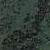

In [55]:
im = Image.open(PATH+"/no_pools/img1194.jpg")
im

**Define the DataBlock for the pool detection task**

In [56]:
poolDetection = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(50),
    batch_tfms=aug_transforms())

**Create dataloaders for the pool detection dataset**

In [57]:
dls = poolDetection.dataloaders(PATH)

**Display a batch of validation images**

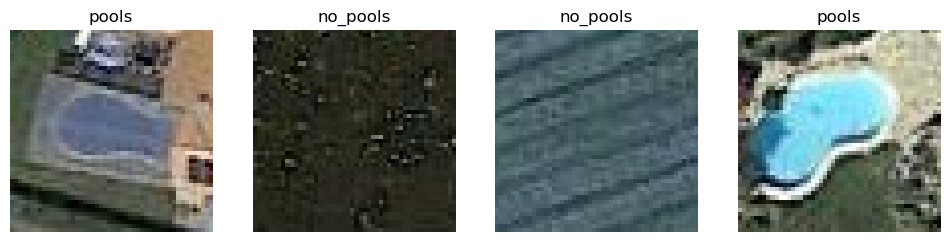

In [58]:
dls.valid.show_batch(max_n=4, nrows=1)

**Create a CNN learner using the ResNet18 architecture**

In [59]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Running the lerning rate finder to get the best suggested lerning rates and extract the suggested learning rate corresponding to the vallay for the loss curve**

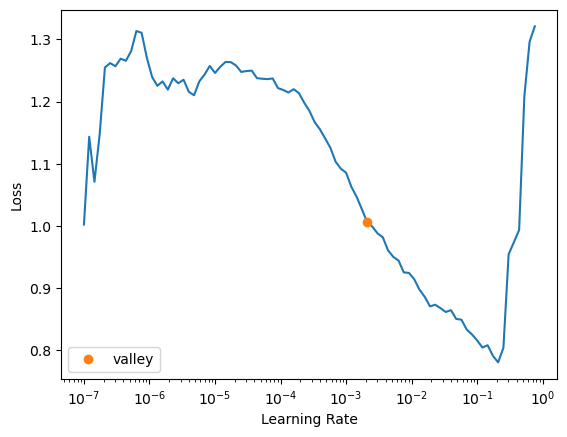

In [60]:
suggested_lrs = learn.lr_find()
lr_min = suggested_lrs.valley

**Setting the number of epochs for the fine tuning of the model, and then fine tune the model using the n_epochs and the suggested lerningrate we found over**

In [61]:
n_epochs = 7 # epochs you like to use
learn.fine_tune(n_epochs, base_lr=lr_min)

epoch,train_loss,valid_loss,error_rate,time
0,0.687972,0.467290,0.130515,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.406872,0.358137,0.102941,00:10
1,0.305095,0.305474,0.071691,00:09
2,0.243231,0.270097,0.058824,00:09
3,0.180526,0.243137,0.053309,00:10
4,0.124933,0.225318,0.056985,00:09
5,0.108032,0.210615,0.055147,00:09
6,0.095090,0.203374,0.049632,00:09


In [62]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.078953,0.262607,0.056985,00:10
1,0.143817,0.462905,0.077206,00:09
2,0.108302,0.119918,0.027574,00:09
3,0.077734,0.099736,0.025735,00:10
4,0.058510,0.098488,0.025735,00:09


**Visualize the model's performance with a confusion matrix**

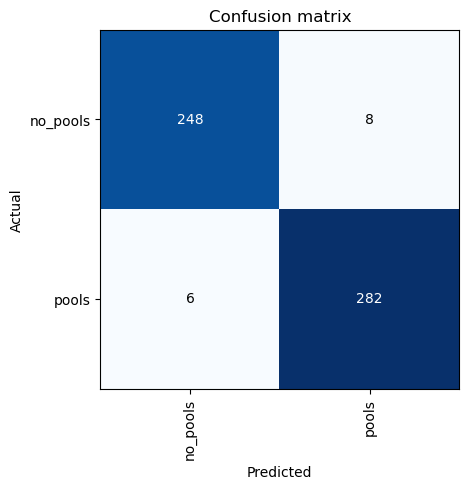

In [63]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**Display the top 5 losses**

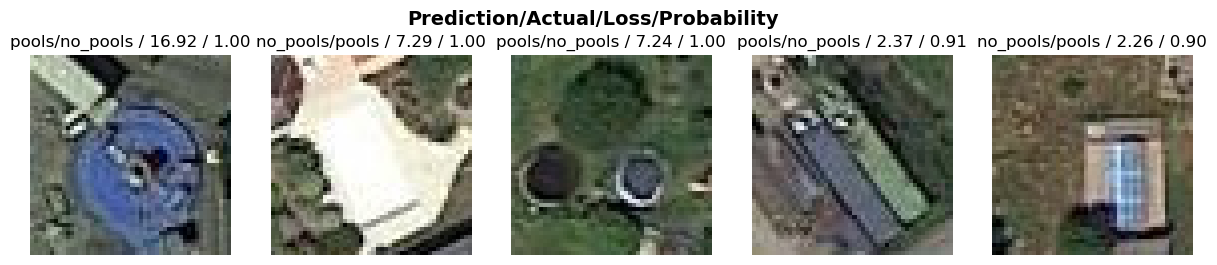

In [64]:
interp.plot_top_losses(5, nrows=1)

**Create an ImageClassifierCleaner for cleaning the dataset**

In [65]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Did not want to clean my dataset but by running this code bellow its possible

In [66]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

**Export the trained model**

In [67]:
learn.export('firstModel6.pkl')